# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [10]:
#df['value_log'] = np.log(df['value'])

In [11]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


target,user_id
i32,u32
0,1227381
1,647575


In [12]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [13]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19044\276488151.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [14]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()

In [15]:
from local_utils import *

# Список колонок для логарифмирования
columns_to_log = [
    'num_products_click',
    'sum_discount_price_click',
    'max_discount_price_click',
    'num_products_favorite',
    'sum_discount_price_favorite',
    'max_discount_price_favorite',
    'num_products_order',
    'sum_discount_price_order',
    'max_discount_price_order',
    'num_products_to_cart',
    'sum_discount_price_to_cart',
    'max_discount_price_to_cart',
    'num_search',
    'unique_search_queries',
    'num_search_last_month',
    'num_search_last_week',
    'search_daily_rate',
    'search_cluster_switches',
    'search_mean_cluster_switch_days',
    'search_mean_query_len',
    'search_main_cluster_query_len_diff'
]

# Применяем преобразование
df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=False)

# Дополнительно: приводим все числовые колонки к float32
for col in df_pd.select_dtypes(include=['float64', 'int64']).columns:
    df_pd[col] = df_pd[col].astype('float32')

c:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

tr, val = get_split(df_pd, val_size=0.3)

'''cols = [
    # Существующие столбцы
    'num_products_click', 
    'sum_discount_price_click', 'max_discount_price_click',
    'days_since_last_click', 'days_since_first_click',
    'num_products_favorite', 'sum_discount_price_favorite',
    'max_discount_price_favorite', 'days_since_last_favorite',
    'days_since_first_favorite', 'num_products_order',
    'sum_discount_price_order', 'max_discount_price_order',
    'days_since_last_order', 'days_since_first_order',
    'num_products_to_cart', 'sum_discount_price_to_cart',
    'max_discount_price_to_cart', 'days_since_last_to_cart',
    'days_since_first_to_cart', 'num_search', 'days_since_last_search',
    'days_since_first_search', 
    'main_search_cluster', 'num_search_clusters',
    
    # Новые столбцы из анализа поиска
    'unique_search_queries',               # Количество уникальных поисковых запросов
    'num_search_last_month',               # Поисков за последний месяц
    'num_search_last_week',                # Поисков за последнюю неделю
    'search_daily_rate',                   # Среднедневная частота поисков
    'recent_search_cluster',               # Последний доминирующий кластер
    'search_cluster_concentration',        # Концентрация интересов
    'search_cluster_switches',             # Переключения между кластерами
    'search_cluster_stability',            # Стабильность кластеров
    'main_search_cluster_time_ratio',      # Время в основном кластере
    'search_mean_cluster_switch_days',     # Среднее время между сменами кластеров
    'search_mean_query_len',               # Средняя длина запроса
    'search_main_cluster_query_len_diff',  # Разница длины запросов
]'''

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 'last_order_time', 'first_order_time', 
                                  'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time', 'top3_search_counts', 'search_cluster_entropy', 'top3_search_clusters'})

params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)


[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 453626, number of negative: 858842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12212
[LightGBM] [Info] Number of data points in the train set: 1312468, number of used features: 58
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345628 -> initscore=-0.638312
[LightGBM] [Info] Start training from score -0.638312
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 60 rounds
Did not meet early stopping. Best iteration is

feature_importance: [ 438  909   68   87  261  359   31  494  448    0  117  236  265  542
  553  405  194 1135 1221   47  702    0  284  603 1555  260   79  114
  293  114  119  689 1923    0   52   92  194  711    0    6  228    0
   97  649 1345   33  458  241    1  430   46    2 1836    4    0    0
    0    0] 



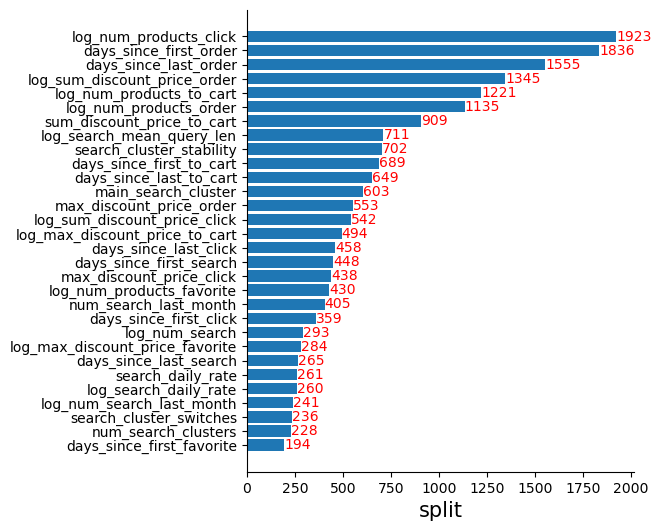

In [17]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [18]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_19044\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [19]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19044\555555092.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [20]:
df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()
df_pd = df_pd[df_pd['user_id'] != 2346229]

In [21]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
    
df_pd = df_main.to_pandas()


In [22]:
from local_utils import *

# Список колонок для логарифмирования
columns_to_log = [
    'num_products_click',
    'sum_discount_price_click',
    'max_discount_price_click',
    'num_products_favorite',
    'sum_discount_price_favorite',
    'max_discount_price_favorite',
    'num_products_order',
    'sum_discount_price_order',
    'max_discount_price_order',
    'num_products_to_cart',
    'sum_discount_price_to_cart',
    'max_discount_price_to_cart',
    'num_search',
    'unique_search_queries',
    'num_search_last_month',
    'num_search_last_week',
    'search_daily_rate',
    'search_cluster_switches',
    'search_mean_cluster_switch_days',
    'search_mean_query_len',
    'search_main_cluster_query_len_diff'
]

# Применяем преобразование
df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=False)

# Дополнительно: приводим все числовые колонки к float32
for col in df_pd.select_dtypes(include=['float64', 'int64']).columns:
    df_pd[col] = df_pd[col].astype('float32')

c:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
from local_utils import *

df_pd['predict'] = model.predict_proba(df_pd[cols])[:, 1]

In [25]:
df_pd[['user_id', 'predict']]

,user_id,predict
0,1031612,0.827985
1,5000457,0.790444
2,4976606,0.436717
3,4220387,0.783583
4,89027,0.168441
...,...,...
1874951,10671732,0.162139
1874952,4791088,0.321687
1874953,9449538,0.172572
1874954,522201,0.722878


In [28]:
df_pd[['user_id', 'predict']].to_csv('try_to_repeat_score_1.csv', index=False)

In [27]:
в

NameError: name 'в' is not defined

In [ ]:
df_copy = df_pd.copy()

In [ ]:
df_copy['log_num_products_click'] = np.log(df_copy['num_products_click'])
df_copy['log_sum_discount_price_click'] = np.log(df_copy['sum_discount_price_click'])
df_copy['log_max_discount_price_click'] = np.log(df_copy['max_discount_price_click'])
df_copy['log_num_products_favorite'] = np.log(df_copy['num_products_favorite'])
df_copy['log_sum_discount_price_favorite'] = np.log(df_copy['sum_discount_price_favorite'])
df_copy['log_max_discount_price_favorite'] = np.log(df_copy['max_discount_price_favorite'])
df_copy['log_num_products_order'] = np.log(df_copy['num_products_order'])
df_copy['log_sum_discount_price_order'] = np.log(df_copy['sum_discount_price_order'])
df_copy['log_max_discount_price_order'] = np.log(df_copy['max_discount_price_order'])
df_copy['log_num_products_to_cart'] = np.log(df_copy['num_products_to_cart'])
df_copy['log_sum_discount_price_to_cart'] = np.log(df_copy['sum_discount_price_to_cart'])
df_copy['log_max_discount_price_to_cart'] = np.log(df_copy['max_discount_price_to_cart'])
df_copy['log_num_search'] = np.log(df_copy['num_search'])
df_copy['log_unique_search_queries'] = np.log(df_copy['unique_search_queries'])
df_copy['log_num_search_last_month'] = np.log(df_copy['num_search_last_month'])
df_copy['log_num_search_last_week'] = np.log(df_copy['num_search_last_week'])
df_copy['log_search_daily_rate'] = np.log(df_copy['search_daily_rate'])
df_copy['log_search_cluster_switches'] = np.log(df_copy['search_cluster_switches'])
df_copy['log_search_mean_cluster_switch_days'] = np.log(df_copy['search_mean_cluster_switch_days'])
df_copy['log_search_mean_query_len'] = np.log(df_copy['search_mean_query_len'])
df_copy['log_search_main_cluster_query_len_diff'] = np.log(df_copy['search_main_cluster_query_len_diff'])


In [ ]:
df_copy['log2_num_products_favorite'] = np.log(df_copy['log_num_products_favorite'])


c:\Users\Admin\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
pretty_print(cols)

['num_products_click', 'sum_discount_price_click', 'max_discount_price_click', 
	'days_since_last_click', 'days_since_first_click', 'num_products_favorite', 
	'sum_discount_price_favorite', 'max_discount_price_favorite', 'days_since_last_favorite', 
	'days_since_first_favorite', 'num_products_order', 'sum_discount_price_order', 
	'max_discount_price_order', 'days_since_last_order', 'days_since_first_order', 
	'num_products_to_cart', 'sum_discount_price_to_cart', 'max_discount_price_to_cart', 
	'days_since_last_to_cart', 'days_since_first_to_cart', 'num_search', 'days_since_last_search', 
	'days_since_first_search', 'main_search_cluster', 'num_search_clusters', 
	'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 
	'recent_search_cluster', 'search_cluster_concentration', 'search_cluster_switches', 
	'search_cluster_stability', 'main_search_cluster_time_ratio', 
	'search_mean_cluster_switch_days', 'search_mean_query_len', 
	'search_main_cluster

In [ ]:
log_columns = [col for col in df_copy.columns if col.startswith('log_')]

['log_num_products_click', 'log_sum_discount_price_click', 'log_max_discount_price_click', 'log_num_products_favorite', 'log_sum_discount_price_favorite', 'log_max_discount_price_favorite', 'log_num_products_order', 'log_sum_discount_price_order', 'log_max_discount_price_order', 'log_num_products_to_cart', 'log_sum_discount_price_to_cart', 'log_max_discount_price_to_cart', 'log_num_search', 'log_unique_search_queries', 'log_num_search_last_month', 'log_num_search_last_week', 'log_search_daily_rate', 'log_search_cluster_switches', 'log_search_mean_cluster_switch_days', 'log_search_mean_query_len', 'log_search_main_cluster_query_len_diff']


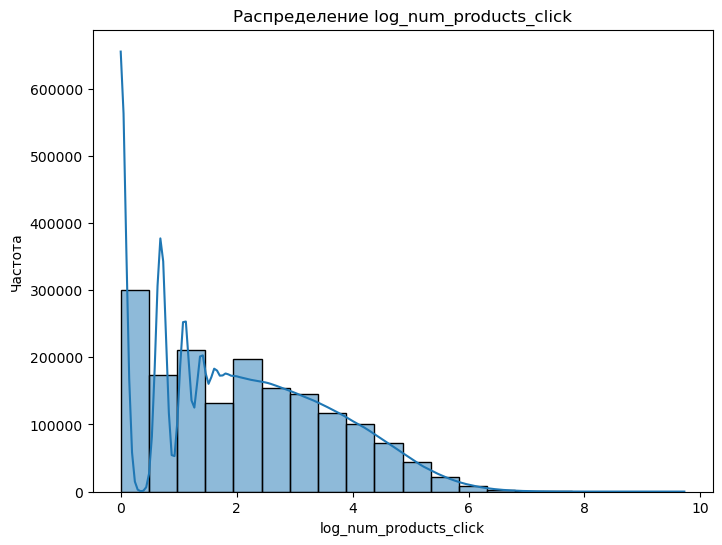

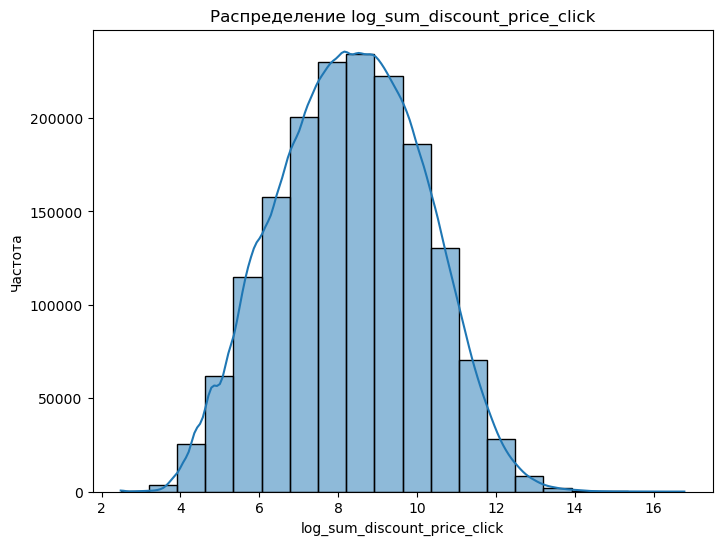

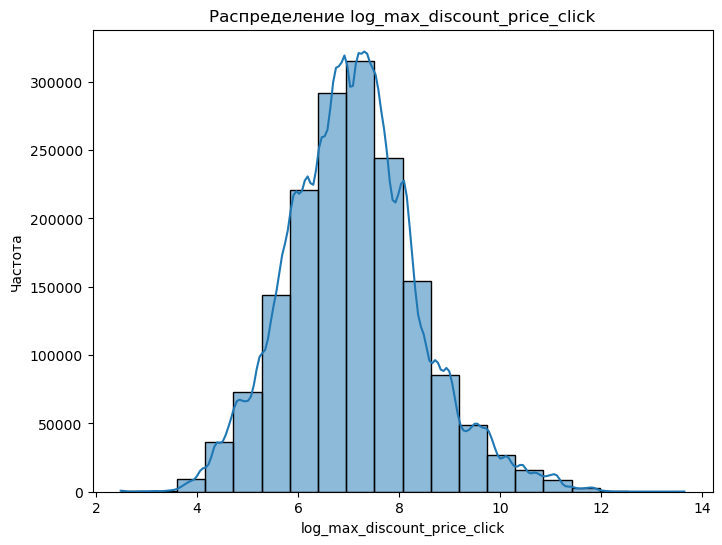

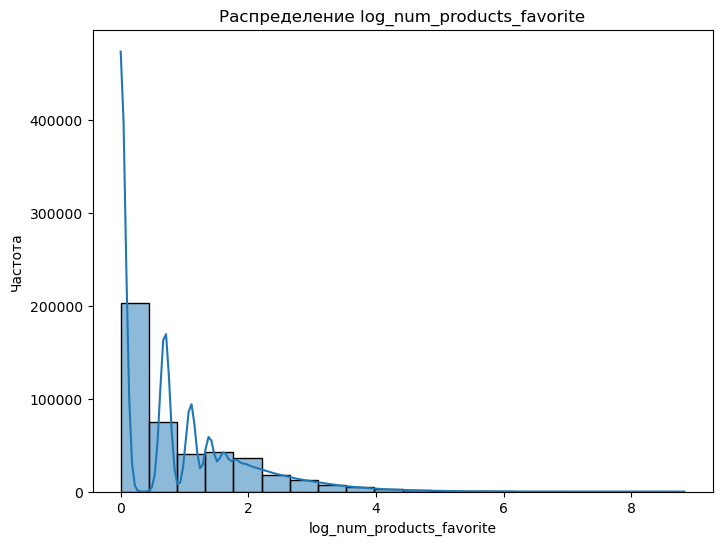

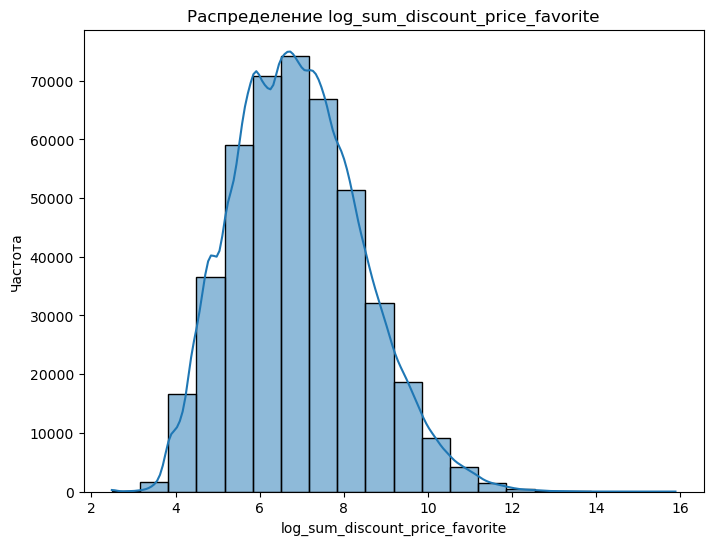

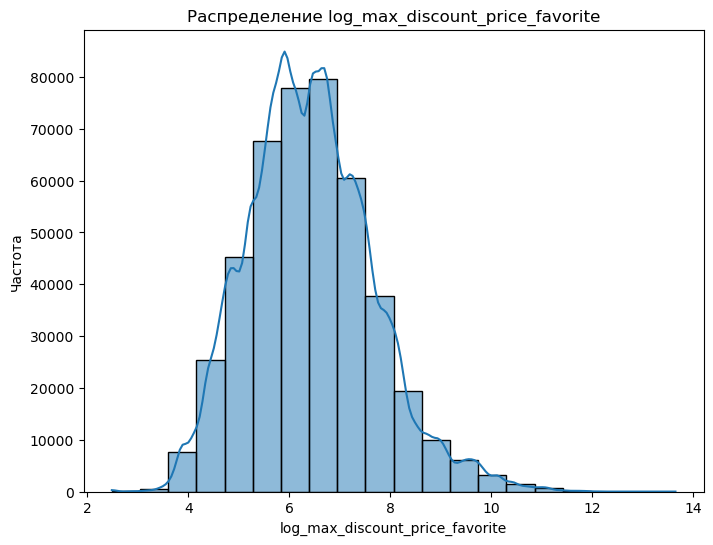

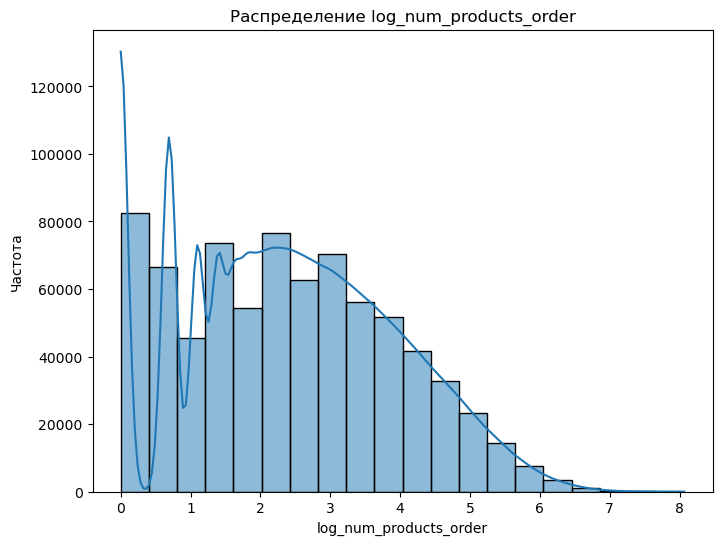

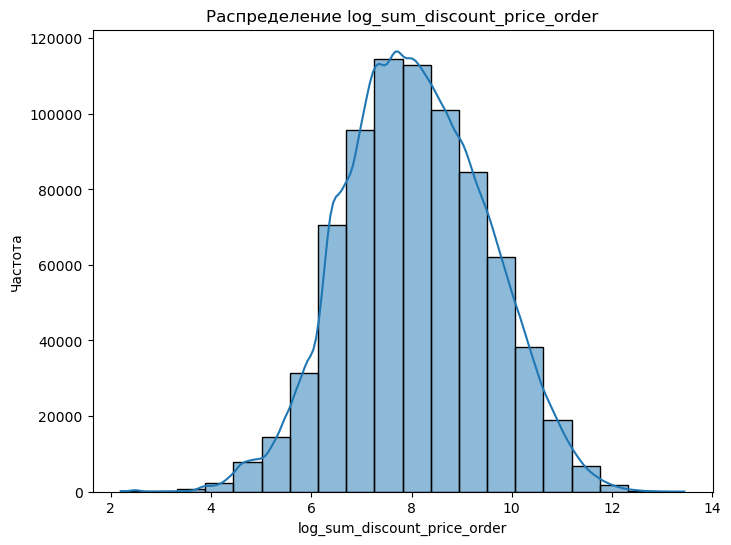

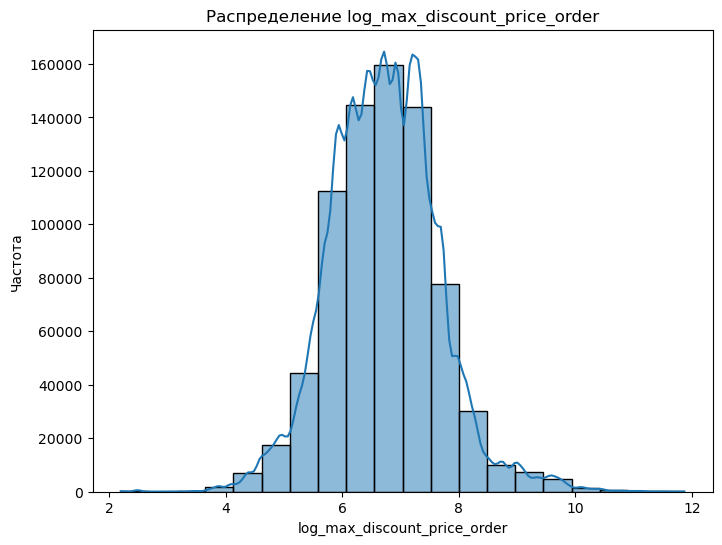

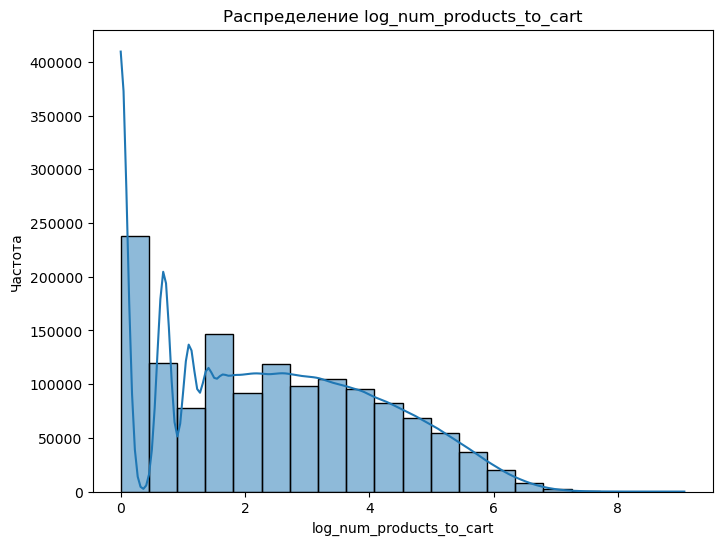

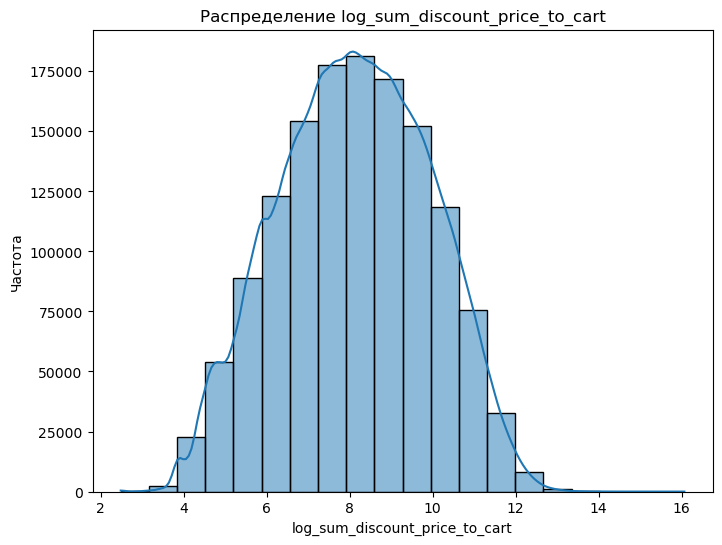

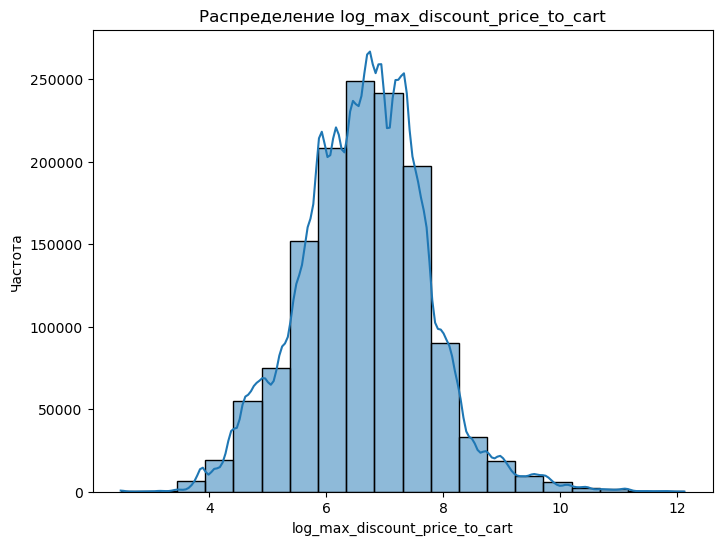

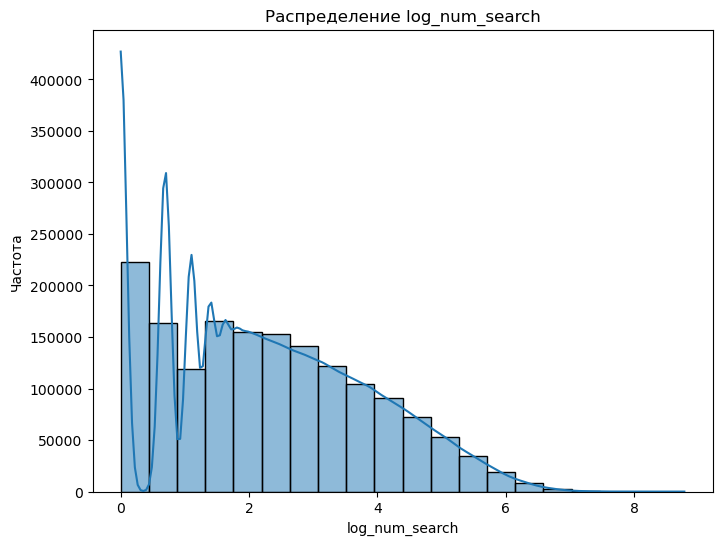

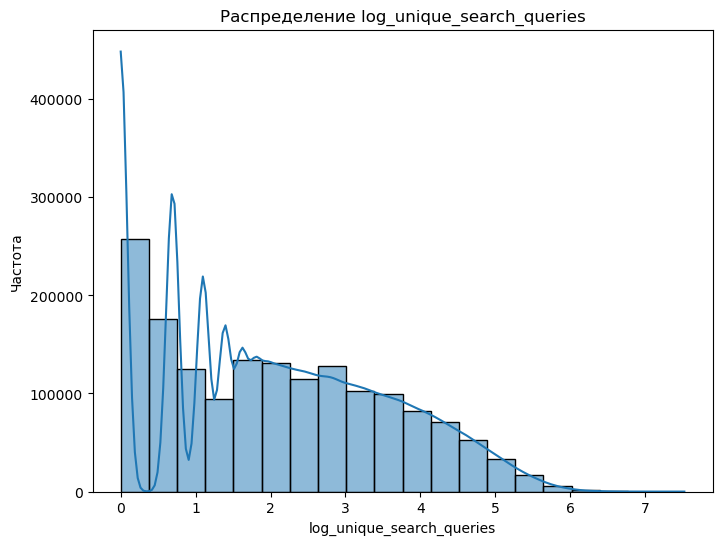

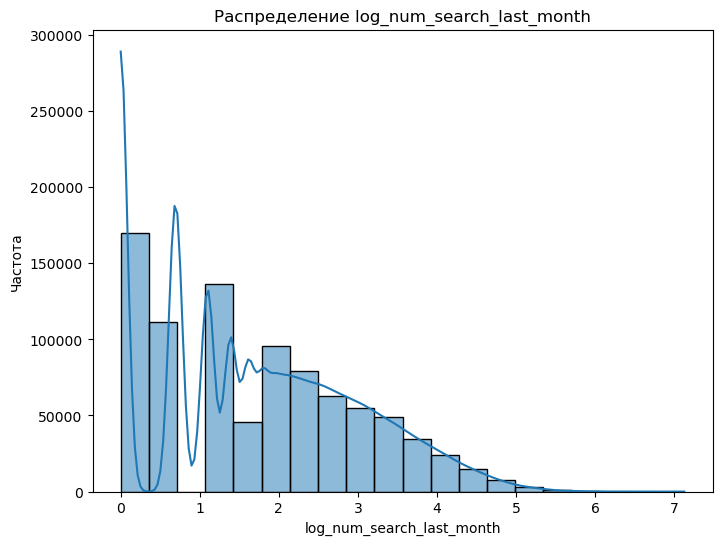

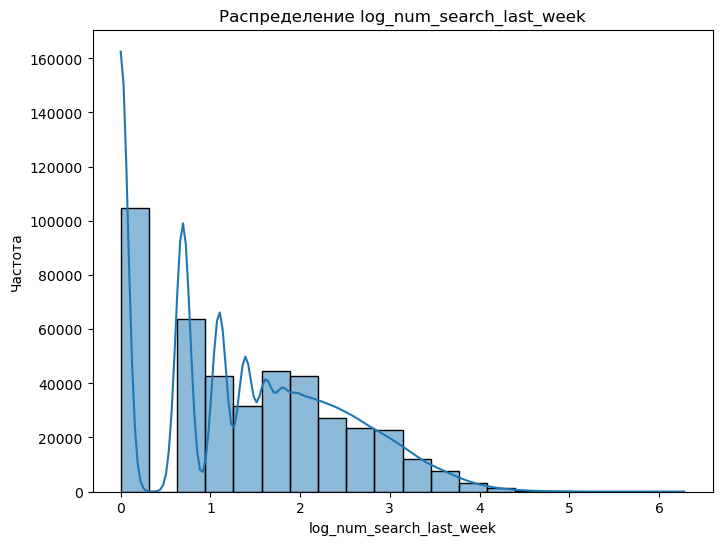

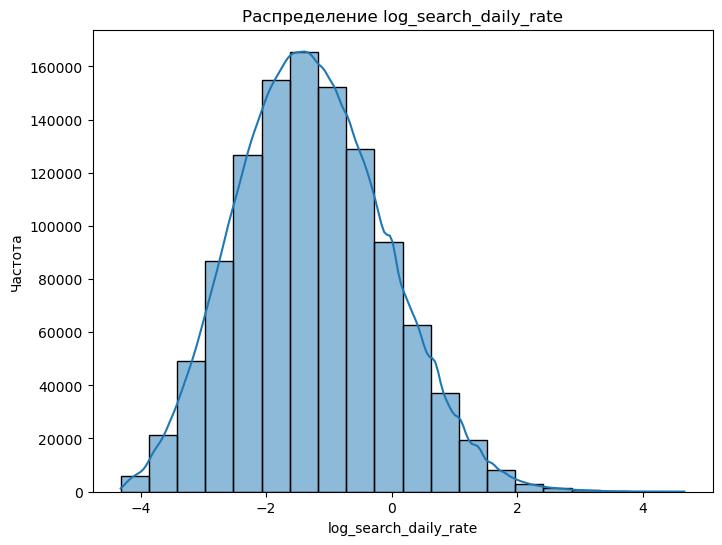

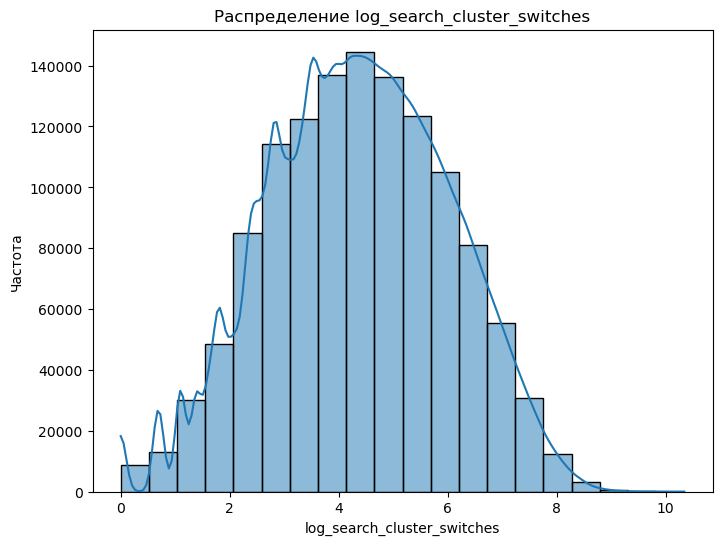

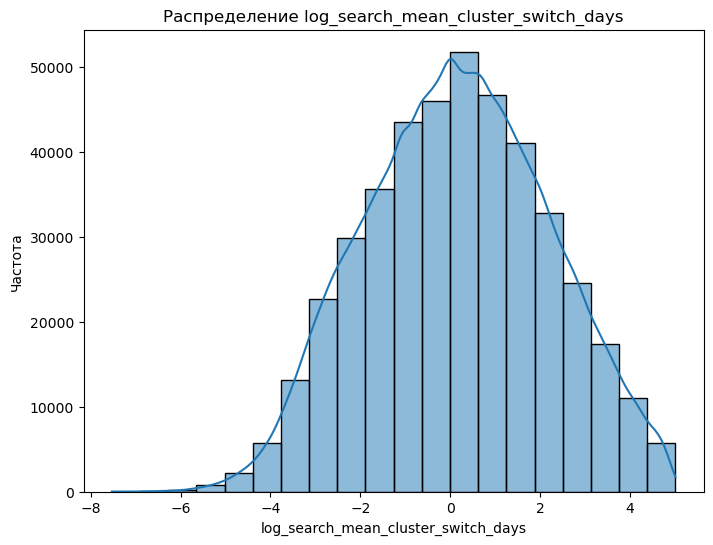

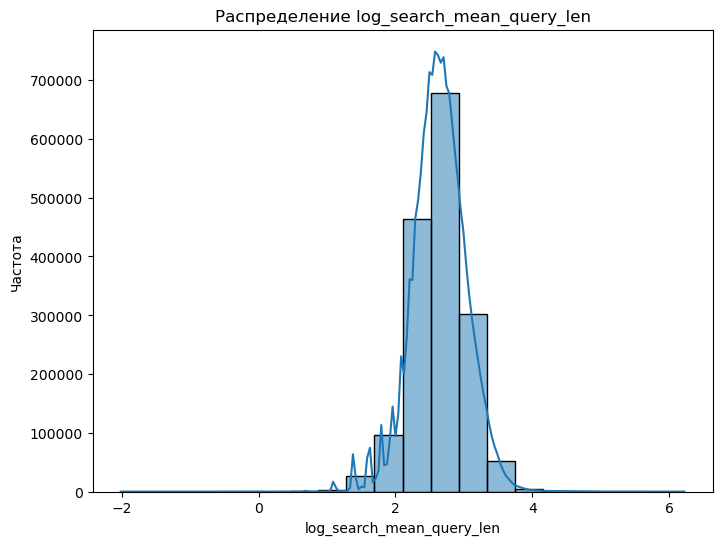

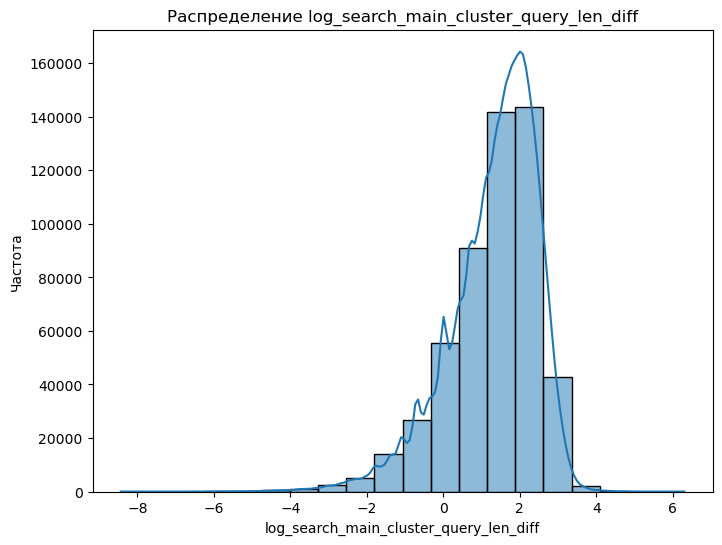

In [ ]:
from local_utils import *

plot_feature_distributions(df_copy[log_columns], log_columns)